In [168]:
# Import my code
from tensorfactorization.utils import (defactorizing_CP, create_initial_data, random_cp_with_noise)
from tensorfactorization.multiplicative import (tensor_factorization_cp_multiplicative, tensor_factorization_cp_multiplicative_poisson)
from tensorfactorization.poisson import (BacktrackingWarning, tensor_factorization_cp_poisson, tensor_factorization_cp_poisson_fixed_step_size)

from toolkit.constants import (
    picture_folder, data_folder, 
    error_label, iteration_label, tensor_dimension_label, time_label, 
    xscale_convergence_data, xscale_convergence, yscale_convergence
)
from toolkit.classes import (
    IterationResult,
    Factorizer
)
from toolkit.evaluate import (
    evaluate_on_random, evaluate_on_data, evaluate_on_images, 
    plot_calculation_times_and_niter
)
from data.data_imports import load_indian_pines

#%matplotlib widget
import tensorly as tl
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pickle # use pickle to save results to disk
import warnings

from skimage import data

from copy import deepcopy

In [144]:
def find_optimal_cp_rank(
    tensor,
    max_rank,
    tolerance=1e-3,  # Threshold for "significant drop" in error
    min_error_diff=None, # Alternative: minimum absolute error difference to consider significant
    n_initializations=3, # Number of random initializations for CP-ALS
    random_state=None,   # For reproducibility
    plot_error=True      # Whether to plot the error curve
):
    """
    Finds an optimal CP rank by iteratively increasing the rank and monitoring
    the relative reconstruction error. Stops when the relative error improvement
    falls below a specified tolerance.

    Parameters
    ----------
    tensor : tl.tensor
        The input tensor to decompose.
    max_rank : int
        The maximum rank to test.
    tolerance : float, optional
        The relative change in error below which to stop.
        (current_error - previous_error) / previous_error < tolerance.
        Defaults to 1e-3 (0.1%).
    min_error_diff : float, optional
        An alternative or additional stopping criterion. If the absolute
        difference in error (previous_error - current_error) falls below
        this value, stop. Useful for very small absolute changes.
    n_initializations : int, optional
        Number of random initializations for CP-ALS for each rank. The best
        (lowest error) decomposition is chosen. Defaults to 3.
    random_state : int or None, optional
        Seed for the random number generator for reproducibility.
        Defaults to None (no fixed seed).
    plot_error : bool, optional
        If True, plots the relative reconstruction error vs. rank. Defaults to True.

    Returns
    -------
    int
        The suggested optimal rank.
    list
        A list of (rank, relative_error) tuples.
    """

    if random_state is not None:
        np.random.seed(random_state)

    errors = []
    best_rank = 1
    previous_error = float('inf')

    print(f"Starting CP rank determination (max_rank={max_rank}, tolerance={tolerance})")
    print("-" * 50)

    for rank in range(1, max_rank + 1):
        print(f"Testing rank {rank}...")
        current_rank_errors = []
        for i in range(n_initializations):
            try:
                # CP-ALS decomposition
                # 'mask' is useful if you have missing values, but for this example, we assume none
                cp_factorization, RE = tl.decomposition.non_negative_parafac(tensor, rank=rank, init='random', n_iter_max=1000, tol=1e-8, return_errors=True)

                # Reconstruct the tensor
                #reconstructed_tensor = tl.cp_to_tensor(cp_factorization)

                # Calculate the relative reconstruction error
                #error = tl.norm(tensor - reconstructed_tensor) / tl.norm(tensor)
                current_rank_errors.append(tl.to_numpy(RE[-1]))
            except Exception as e:
                print(f"  Warning: Error during decomposition for rank {rank}, initialization {i}: {e}")
                # If an error occurs (e.g., degeneracy), skip this initialization
                current_rank_errors.append(float('inf'))

        if not current_rank_errors:
            print(f"  No successful initializations for rank {rank}. Stopping.")
            break

        # Take the minimum error across initializations for the current rank
        current_error = min(current_rank_errors)
        errors.append((rank, current_error))
        print(f"  Rank {rank} - Min Relative Error: {current_error:.6f}")

        if rank > 1:
            # Calculate the relative improvement
            # We want (previous_error - current_error) / previous_error
            # If previous_error is 0 (perfect fit), this would be undefined, but unlikely with real data
            if previous_error == 0:
                relative_improvement = 0
            else:
                relative_improvement = (previous_error - current_error) / previous_error

            absolute_difference = previous_error - current_error

            print(f"  Relative Improvement from Rank {rank-1} to {rank}: {relative_improvement:.6f}")
            print(f"  Absolute Difference from Rank {rank-1} to {rank}: {absolute_difference:.6f}")

            # Stopping criteria
            should_stop_relative = relative_improvement < tolerance
            should_stop_absolute = False
            if min_error_diff is not None:
                should_stop_absolute = absolute_difference < min_error_diff

            if should_stop_relative or should_stop_absolute:
                print(f"\nStopping at Rank {rank-1}:")
                if should_stop_relative:
                    print(f"  Relative error improvement ({relative_improvement:.6f}) below tolerance ({tolerance}).")
                if should_stop_absolute:
                    print(f"  Absolute error difference ({absolute_difference:.6f}) below min_error_diff ({min_error_diff}).")
                best_rank = rank - 1 # The previous rank was the last "significant" one
                break
        
        previous_error = current_error
        best_rank = rank # Default to current rank if loop continues

    print("-" * 50)
    print(f"Suggested Optimal Rank: {best_rank}")

    if plot_error:
        ranks_tested = [e[0] for e in errors]
        error_values = [e[1] for e in errors]

        plt.figure(figsize=(10, 6))
        plt.plot(ranks_tested, error_values, marker='o', linestyle='-')
        plt.title('Relative Reconstruction Error vs. CP Rank')
        plt.xlabel('Rank')
        plt.ylabel('Relative Reconstruction Error')
        plt.xticks(ranks_tested)
        plt.grid(True, linestyle='--', alpha=0.7)
        if best_rank is not None and best_rank > 0:
            plt.axvline(x=best_rank, color='r', linestyle='--', label=f'Suggested Rank: {best_rank}')
            plt.legend()
        plt.show()

    return best_rank, errors

In [175]:
def find_best_rank(tensor, n_initializations=3, J_max=10, max_iter=200, algorithm=None):
    if algorithm == None:
        algorithm = tensor_factorization_cp_multiplicative
    best_J = 0
    approx_errors = [0]
    for J in range(1,J_max+1):
        print(J)
        current_errors = []
        for _ in range(n_initializations):
            _, RE = tl.decomposition.non_negative_parafac(tensor, J, return_errors=True)
            current_errors.append(tl.to_numpy(RE[-1]))
        approx_errors.append(min(current_errors))

        if J < 2:
            continue
        prev_slope = approx_errors[-2] - approx_errors[-3]
        current_slope = approx_errors[-1] - approx_errors[-2]
        print(current_slope)
        #print(prev_slope)
        if current_slope > -0.01:
            print(f"The correct rank is {J-1}")
            best_J = J-1
            #break
    x = range(1, len(approx_errors))
    print(x)
    plt.plot(x, approx_errors[1:])
    plt.xticks(x)
    return best_J

1
2
-0.042365372
3
-0.027193606
4
-0.034751892
5
-0.019846857
6
-0.016119957
7
-0.016251683
8
-0.014888406
9
-0.008293927
The correct rank is 8
10
-0.011734784
range(1, 11)


8

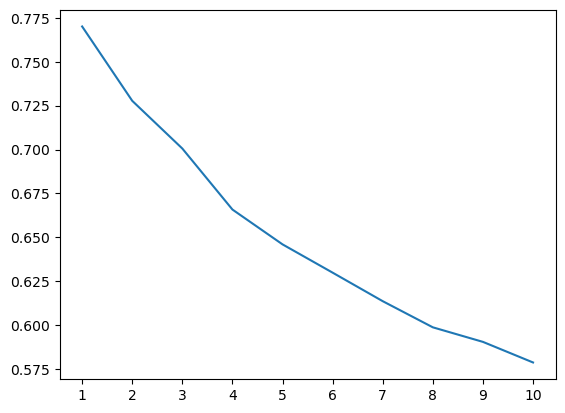

In [177]:
# run the factorization on gpu
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
tensor = random_cp_with_noise((10,10,10), 5, context=context)
#find_best_rank(tensor)

tensor = tl.tensor(data.hubble_deep_field(), **context)
#find_best_rank(tensor, J_max=10)

tensor = tl.tensor(load_indian_pines().tensor, **context)
#find_best_rank(tensor)

# TODO this one does not seme to work here?
tensor = tl.tensor(np.load("data/vaccine_tensor.npy"), **context)
#print(tensor)
find_best_rank(tensor)